In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fancyimpute import BiScaler, SoftImpute, IterativeSVD, MICE, MatrixFactorization
from __future__ import division
# configure matplotlib plots
%matplotlib inline
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = [10, 7.5] #[12, 9]#
mpl.rcParams['figure.dpi'] = 90
mpl.rcParams['savefig.dpi'] = 100
# configure seaborn plots
sns.set(style="whitegrid", color_codes=True)

# Import Cross Validation & Machine Learning Algorithms
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.isotonic import IsotonicRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [2]:
# functions
def featureNorm(data, kind='std'):
    global mu
    global sigma
    if kind == 'range':
        mu = np.min(data)
        sigma = np.max(data) - np.min(data)
    else:
        mu = np.mean(data)
        sigma = np.std(data)
    return (data - mu) / sigma

In [3]:
df1 = pd.read_table('data/orange_small_train.data', delimiter='\t', encoding='ascii')
df1.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [4]:
print df1.shape #, df2.shape
df = df1 # pd.concat([df1, df2])
print df.shape
df.head()

(50000, 230)
(50000, 230)


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [5]:
#churn = pd.read_csv('orange_large_train_churn.txt', header=None)
appetency = pd.read_csv('data/orange_small_train_appetency.txt', header=None)
upsell = pd.read_csv('data/orange_small_train_upselling.txt', header=None)

y1 = np.asarray(appetency).reshape(appetency.shape[0], )
y2 = np.asarray(upsell).reshape(upsell.shape[0], )
appetency.shape, upsell.shape

((50000, 1), (50000, 1))

In [6]:
appetency.columns = ['app']
appetency['app'].value_counts()

-1    49110
 1      890
Name: app, dtype: int64

In [7]:
upsell.columns = ['up']
upsell['up'].value_counts()

-1    46318
 1     3682
Name: up, dtype: int64

## Categorical Processing

(34,)

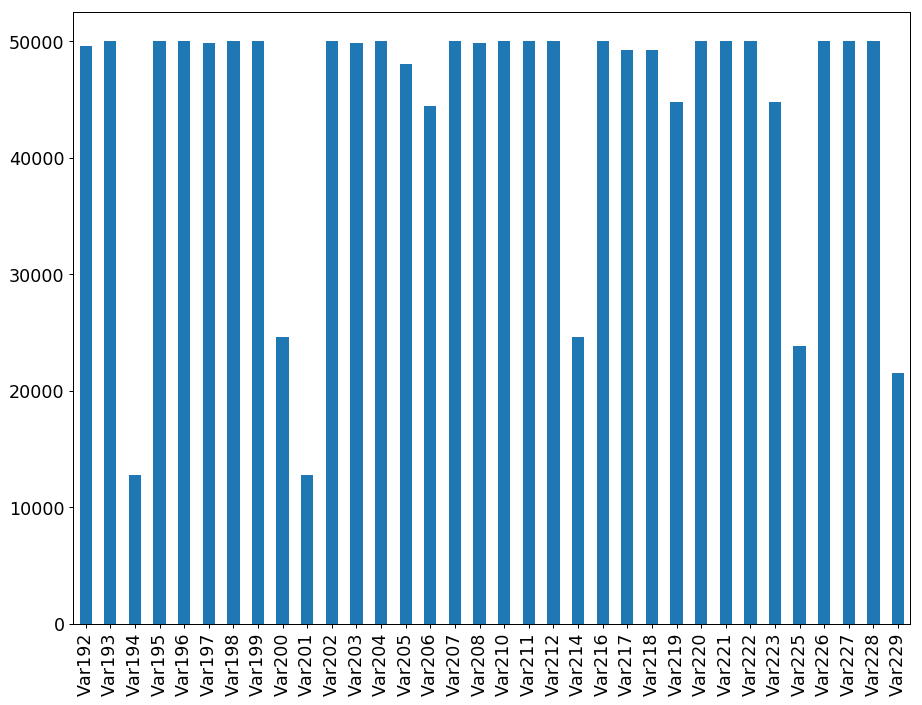

In [21]:
# categorical vars with at least 10000 samples
usable_n[(usable_n>=10000) & (dtypeMask==0)].plot.bar()
usable_n[(usable_n>=10000) & (dtypeMask==0)].shape

In [8]:
df.dtypes

Var1      float64
Var2      float64
Var3      float64
Var4      float64
Var5      float64
Var6      float64
Var7      float64
Var8      float64
Var9      float64
Var10     float64
Var11     float64
Var12     float64
Var13     float64
Var14     float64
Var15     float64
Var16     float64
Var17     float64
Var18     float64
Var19     float64
Var20     float64
Var21     float64
Var22     float64
Var23     float64
Var24     float64
Var25     float64
Var26     float64
Var27     float64
Var28     float64
Var29     float64
Var30     float64
           ...   
Var201     object
Var202     object
Var203     object
Var204     object
Var205     object
Var206     object
Var207     object
Var208     object
Var209    float64
Var210     object
Var211     object
Var212     object
Var213     object
Var214     object
Var215     object
Var216     object
Var217     object
Var218     object
Var219     object
Var220     object
Var221     object
Var222     object
Var223     object
Var224     object
Var225    

In [8]:
# assign cat cols the appropriate data type
cat_cols = df.iloc[:, 190:].columns
for col in cat_cols:
    df[col] = df[col].astype('category')

In [9]:
%%time
cat_levels = df.loc[:, df.dtypes == 'category'].apply(pd.Series.nunique)

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 137 ms


CPU times: user 276 ms, sys: 24 ms, total: 300 ms
Wall time: 309 ms


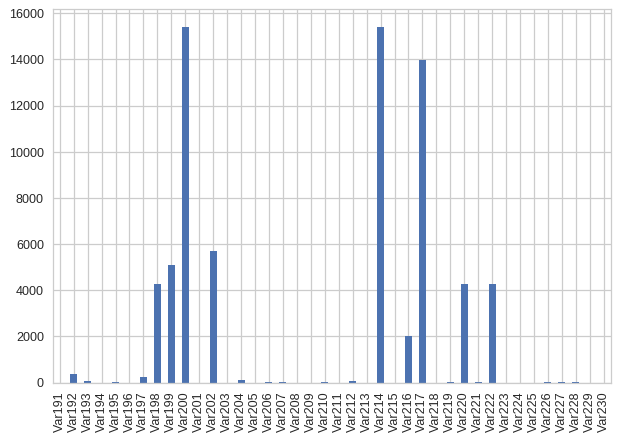

In [9]:
cat_levels.plot.bar()

In [10]:
cats_many = cat_levels[(cat_levels >= 1800)].index.values

In [11]:
other_cutoff = (50, 70, 10, 50, 10, 50, 50, 50, 50)
other_rep = {}
for thresh, col in zip(other_cutoff, cats_many):
    print thresh, col, (df[col].value_counts() > thresh).sum()
    cnts = df[col].value_counts()
    others = cnts[cnts < thresh].index.values
    df[col] = df[col].replace(others, 'other')

50 Var198 163
70 Var199 162
10 Var200 21
50 Var202 81
10 Var214 21
50 Var216 114
50 Var217 74
50 Var220 163
50 Var222 163


In [12]:
# remove cat vars with only one level or too many levels
cats_drop = cat_levels[(cat_levels <= 1)].index.values
df.drop(cats_drop, axis=1, inplace=True)

In [16]:
cats_drop

array([u'Var191', u'Var209', u'Var213', u'Var215', u'Var224', u'Var230'], dtype=object)

In [13]:
# reassign fused category columns as category
for col in cats_many:
    df[col] = df[col].astype('category')
df.Var220.dtype

category

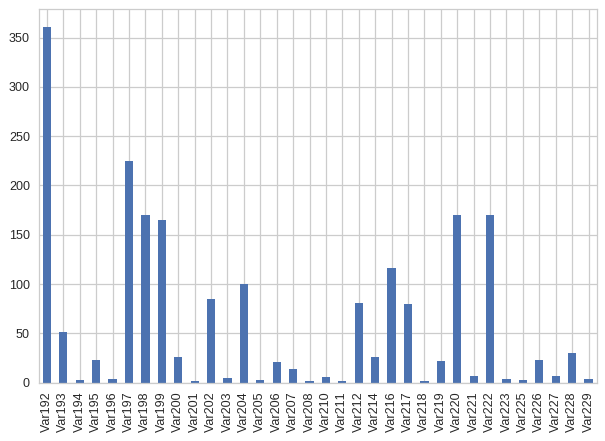

In [26]:
df.loc[:, df.dtypes == 'category'].apply(pd.Series.nunique).plot.bar()

In [14]:
# create 1-hot encoding matrix of cat vars
for i, col in enumerate(df.loc[:, df.dtypes == 'category'].columns):
    if i == 0:
        Xhot = pd.get_dummies(df[col], prefix=col)
    else:
        Xhot = pd.concat([Xhot, pd.get_dummies(df[col], prefix=col)], axis=1)
Xhot.head()

,Var192_0G9vyxdMWg,Var192_0kQTmBU3gb,Var192_0kQqrQsiZt,Var192_0vimfo8zhV,Var192_1GdOj17ejg,Var192_1GdOj1KXzC,Var192_1JGTmBQZiT,Var192_1JGqrQKzJV,Var192_1JGr4RKzJV,Var192_1JGr4RUaLY,...,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_n1OBWGkV3fbsHR75taC,Var228_r_7E,Var228_xwM2aC7IdeMC0,Var229_am7c,Var229_mj86,Var229_oJmt,Var229_sk2h
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
Xhot.shape

(50000, 2013)

## Float processing

In [8]:
# check for number of samples with usable data for each var
usable_n = df.apply(lambda x: x.notnull().sum())
usable_n.shape

(230,)

In [9]:
# data type mask: 1=int; 0=cat
dtypeMask = np.ones(usable_n.shape, dtype=int)
dtypeMask[190:] = 0

(42,)

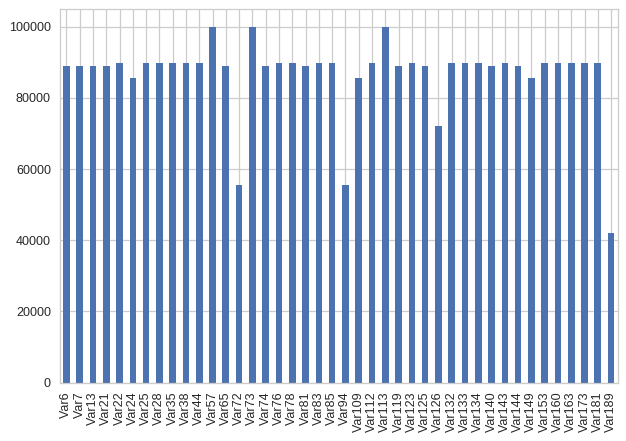

In [13]:
# numeric vars with at least 10000 samples
usable_n[(usable_n>=10000) & (dtypeMask==1)].plot.bar()
usable_n[(usable_n>=10000) & (dtypeMask==1)].shape

In [14]:
nonzero = df.notnull()
nonzero.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,False,False,False,False,False,True,True,False,False,False,...,True,True,True,False,False,True,True,True,False,False
1,False,False,False,False,False,True,True,False,False,False,...,True,True,True,False,False,True,True,True,False,False
2,False,False,False,False,False,True,True,False,False,False,...,True,True,True,False,True,True,True,True,True,False
3,False,False,False,False,False,False,True,False,False,False,...,True,True,True,False,False,True,True,True,False,False
4,False,False,False,False,False,True,True,False,False,False,...,True,True,True,False,True,True,True,True,True,False


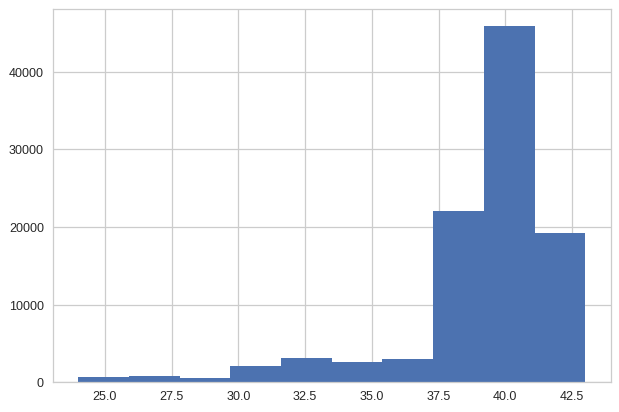

In [26]:
# histogram of samples and number of nonzero variables
nonzero.iloc[:, :190].sum(axis=1).hist()

In [15]:
# create dataframe of only floats and normalize feature floats
X = df.iloc[:, :190]
X = X.apply(lambda x: featureNorm(x, kind='std'))
seed = 71208
X.shape

(50000, 190)

In [25]:
X.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
def testImpute(methods, model, X, y, scoring, suf='', cv_n=10, seed=999, plot=True):
    # test each algorithm
    results = []
    names = []
    for name, imputer in methods:
        # select imputer type
        if name != 'nFlag':
            x = imputer.complete(X)
        else:
            x = X.fillna(-99999)
        kf = StratifiedKFold(n_splits=cv_n, random_state=seed)
        if scoring == 'predict':
            cv_results = cross_val_predict(model, x, y, cv=kf, method=scoring, n_jobs=-1)
        elif scoring == 'featimp':
            imp, std, idx = rfFeatureImp(x, y, seed, suf='upsl')
            cv_results = idx
        else:
            cv_results = cross_val_score(model, x, y, cv=kf, scoring=scoring, n_jobs=-1)
            print("{0}: {1} ({2}) acc (std)".format(name, cv_results.mean(), cv_results.std()))
        results.append(cv_results)
        names.append(name)        
        
    if plot:
        # Plot & Compare model's performance
        fig, ax = plt.subplots()
        ax.boxplot(results, notch=False, patch_artist=True)
        ax.set_xticklabels(names)
        plt.title('Neg Log Loss by Imputation Method', fontsize=20)
        fig = plt.gcf()
        fig.savefig('figs/missing_fill_compare_nlogloss'+ suf+'.png', bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.show()
    return results, names

In [19]:
def rfFeatureImp(X, y, seed, suf, plot=True):
    # Feature Importances from Random Forest
    forests = []

    forest = RandomForestClassifier(n_estimators=500,
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    n_jobs=-1,
                                    class_weight='balanced',
                                    random_state=seed)
    forest.fit(X, y)
    # feature importance, std, and max sorted index
    importance = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importance)[::-1]

    if plot:
        # Plot the Forest's feature importances for each CV split
        fig, ax = plt.subplots(figsize=(34,9))


        ax.set_title("Feature importances: Overall RF")
        ax.bar(range(len(importance)), importance[indices],
               color="b", yerr=std[indices], align="center")
        ax.set_xticks(range(len(importance)))
        ax.set_xticklabels(features[indices], rotation='vertical')
        # ax.set_xticklabels(map(str, indices), rotation='vertical')
        ax.set_xlim([-1, len(importance)])
        fig = plt.gcf()
        fig.savefig('figs/rf_featImp_'+suf+'.png', bbox_inches='tight', pad_inches=0)
        plt.show()
    return importance, std, indices

## OVERALL Random Forest feature importances for upsell

Upsell


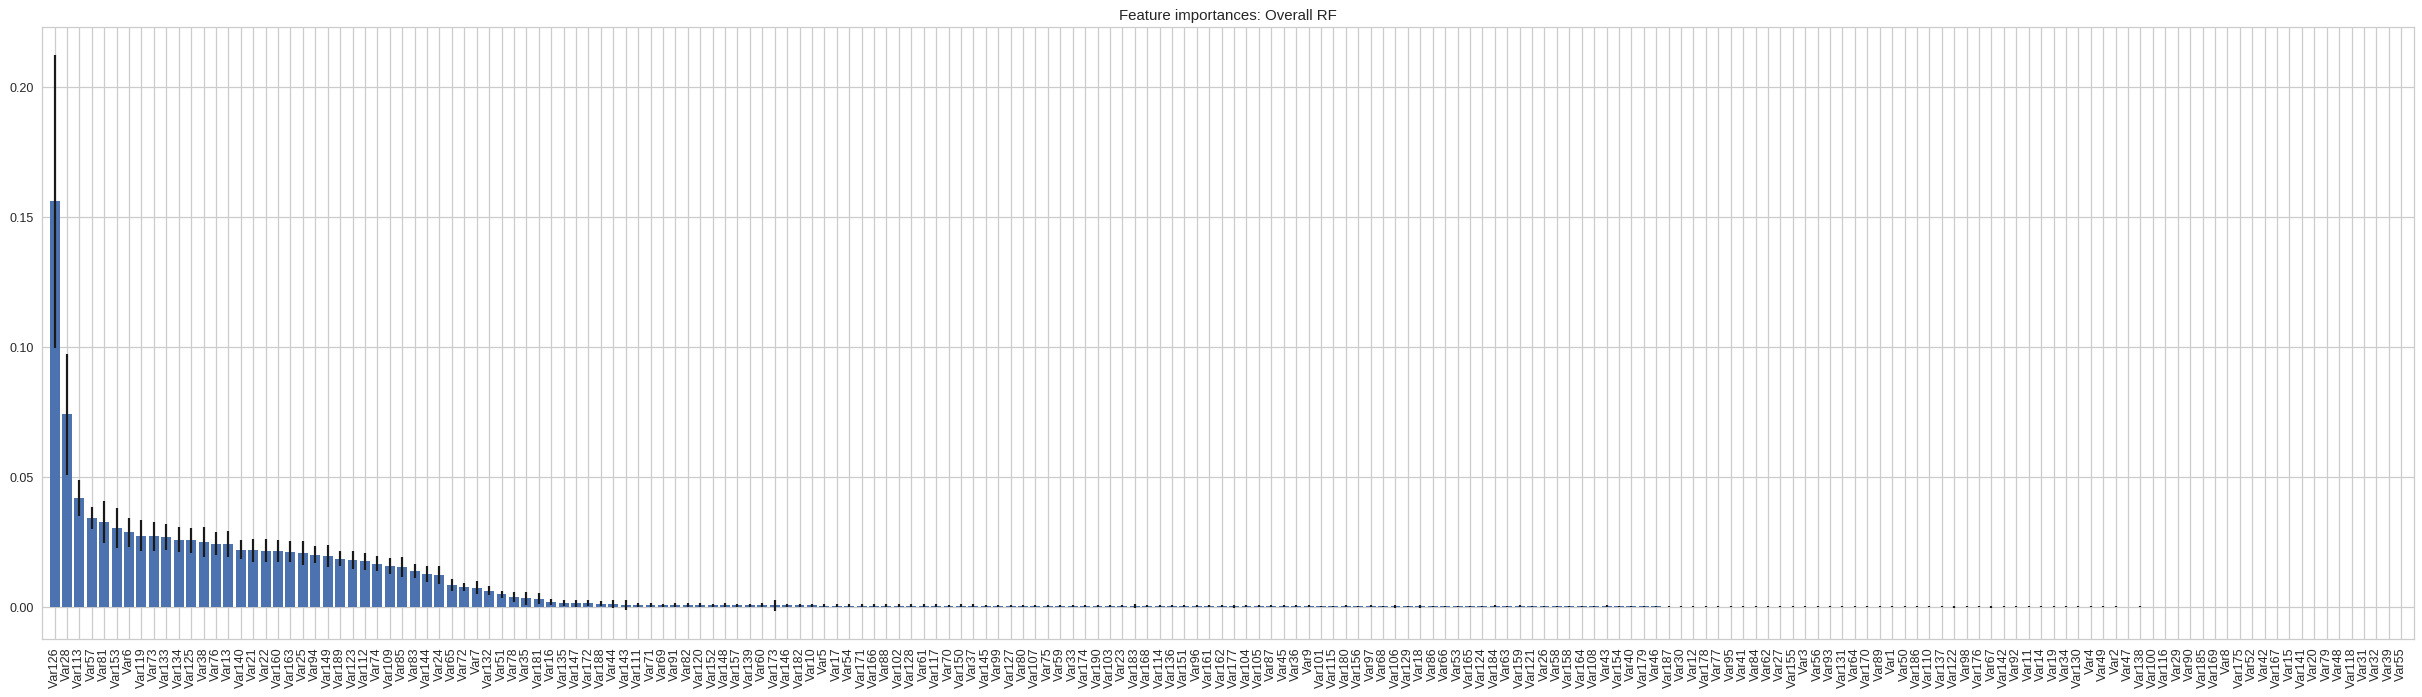

In [53]:
# get OVERALL feature importances for upsell
print('Upsell')
impUp, stdUp, idxUp = rfFeatureImp(X.fillna(-99999), y2, seed, suf='upsl')

In [15]:
imputers = []
#imputers.append(('MICE', MICE()))
imputers.append(('sSVD', SoftImpute(verbose=False)))
imputers.append(('lSVD', IterativeSVD(verbose=False)))
imputers.append(('mFact', MatrixFactorization(verbose=False)))
imputers.append(('nFlag', 'large negative flag'))
#imputers.append(('biSca', BiScaler()))

## Predict Upsell

[SoftImpute] Max Singular Value of X_init = 623.945668
[SoftImpute] Iter 1: observed MAE=0.037047 rank=133
[SoftImpute] Iter 2: observed MAE=0.036845 rank=131
[SoftImpute] Iter 3: observed MAE=0.036789 rank=130
[SoftImpute] Iter 4: observed MAE=0.036767 rank=130
[SoftImpute] Iter 5: observed MAE=0.036754 rank=130
[SoftImpute] Iter 6: observed MAE=0.036744 rank=130
[SoftImpute] Iter 7: observed MAE=0.036736 rank=130
[SoftImpute] Iter 8: observed MAE=0.036730 rank=130
[SoftImpute] Iter 9: observed MAE=0.036724 rank=130
[SoftImpute] Iter 10: observed MAE=0.036718 rank=130
[SoftImpute] Iter 11: observed MAE=0.036713 rank=130
[SoftImpute] Iter 12: observed MAE=0.036708 rank=130
[SoftImpute] Iter 13: observed MAE=0.036704 rank=130
[SoftImpute] Iter 14: observed MAE=0.036700 rank=130
[SoftImpute] Iter 15: observed MAE=0.036696 rank=130
[SoftImpute] Iter 16: observed MAE=0.036693 rank=130
[SoftImpute] Iter 17: observed MAE=0.036690 rank=130
[SoftImpute] Iter 18: observed MAE=0.036686 rank=130


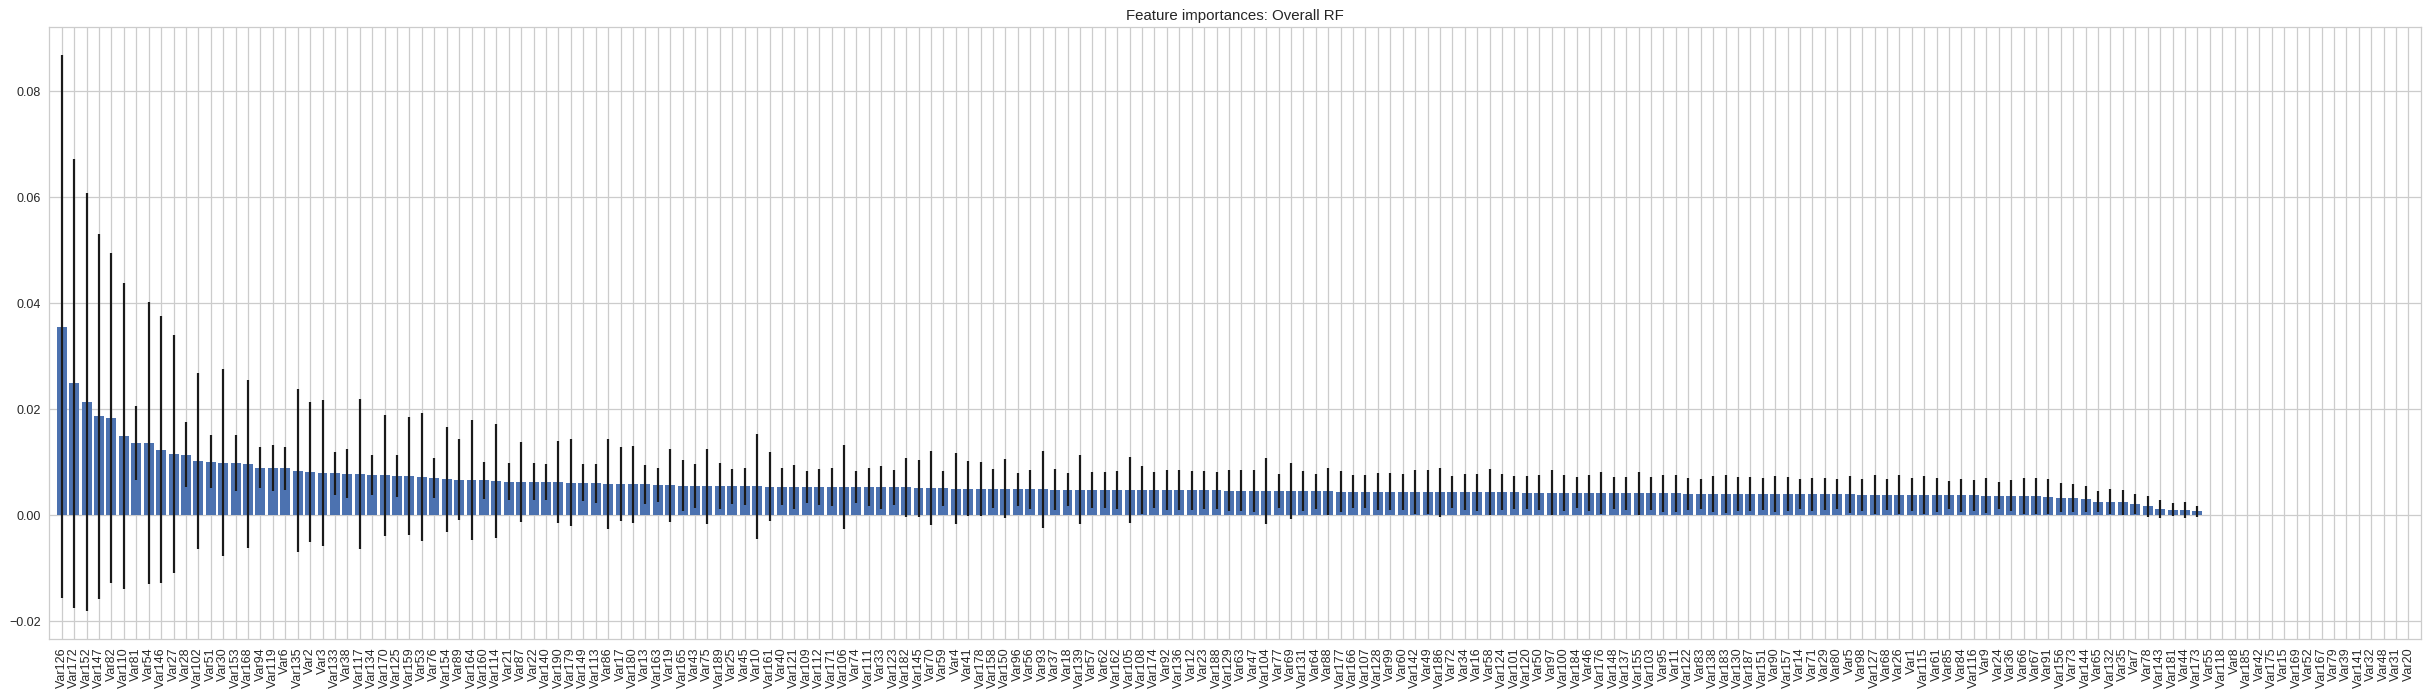

[IterativeSVD] Iter 1: observed MAE=0.472658
[IterativeSVD] Iter 2: observed MAE=0.423330
[IterativeSVD] Iter 3: observed MAE=0.368034
[IterativeSVD] Iter 4: observed MAE=0.309691
[IterativeSVD] Iter 5: observed MAE=0.292752
[IterativeSVD] Iter 6: observed MAE=0.293696
[IterativeSVD] Iter 7: observed MAE=0.294866
[IterativeSVD] Iter 8: observed MAE=0.296065
[IterativeSVD] Iter 9: observed MAE=0.297249
[IterativeSVD] Iter 10: observed MAE=0.298351
[IterativeSVD] Iter 11: observed MAE=0.299291
[IterativeSVD] Iter 12: observed MAE=0.299982
[IterativeSVD] Iter 13: observed MAE=0.300324
[IterativeSVD] Iter 14: observed MAE=0.300333
[IterativeSVD] Iter 15: observed MAE=0.300225
[IterativeSVD] Iter 16: observed MAE=0.300226
[IterativeSVD] Iter 17: observed MAE=0.300362
[IterativeSVD] Iter 18: observed MAE=0.300562
[IterativeSVD] Iter 19: observed MAE=0.300727
[IterativeSVD] Iter 20: observed MAE=0.300785
[IterativeSVD] Iter 21: observed MAE=0.300697
[IterativeSVD] Iter 22: observed MAE=0.3004

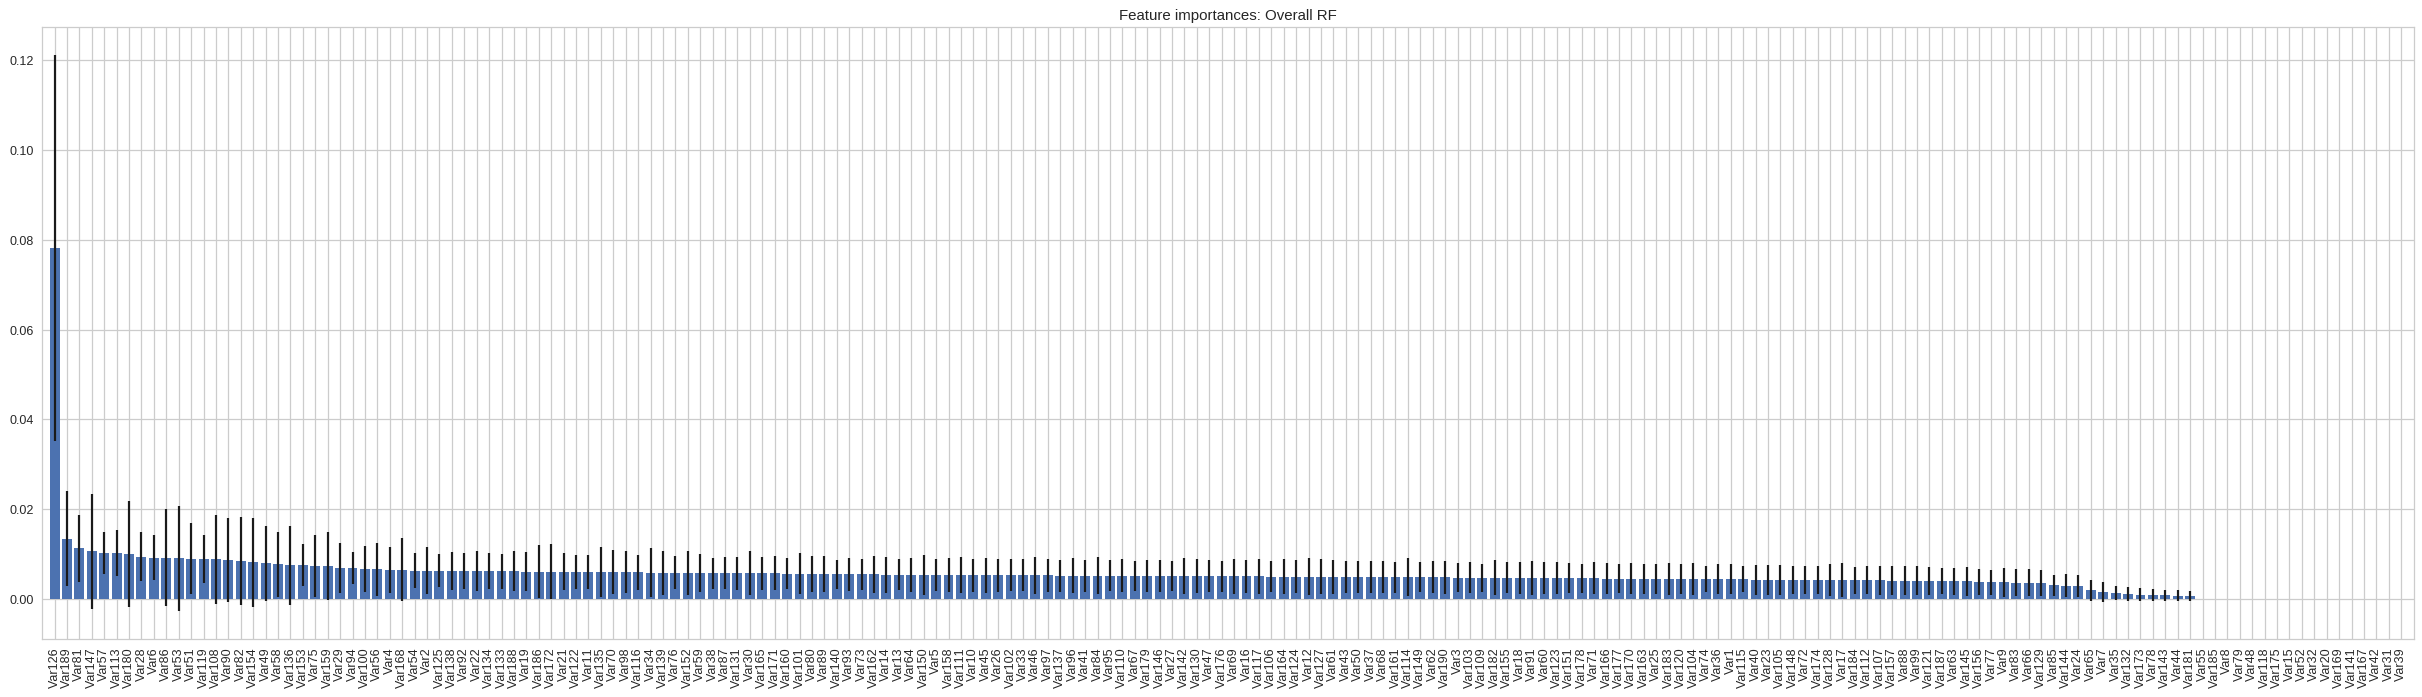

train: 1 of 1 mini-batches from (50000, 190)
downhill: compiling evaluation function
downhill: compiling Adam optimizer
downhill: setting: rms_halflife = 14
downhill: setting: rms_regularizer = 1e-08
downhill: setting: patience = 5
downhill: setting: validate_every = 10
downhill: setting: min_improvement = 0.005
downhill: setting: max_gradient_norm = 5
downhill: setting: max_gradient_elem = 0
downhill: setting: learning_rate = TensorConstant{0.001}
downhill: setting: momentum = 0
downhill: setting: nesterov = False
downhill: validation 0 loss=2.254592 error=2.165587 grad(V)=0.033930 grad(U)=0.000040 *
downhill: Adam 1 loss=2.254592 error=2.165587 grad(V)=0.033930 grad(U)=0.000040
downhill: Adam 2 loss=2.247842 error=2.158953 grad(V)=0.033758 grad(U)=0.000040
downhill: Adam 3 loss=2.238754 error=2.150020 grad(V)=0.033526 grad(U)=0.000039
downhill: Adam 4 loss=2.228161 error=2.139608 grad(V)=0.033257 grad(U)=0.000039
downhill: Adam 5 loss=2.216517 error=2.128164 grad(V)=0.032962 grad(U)=

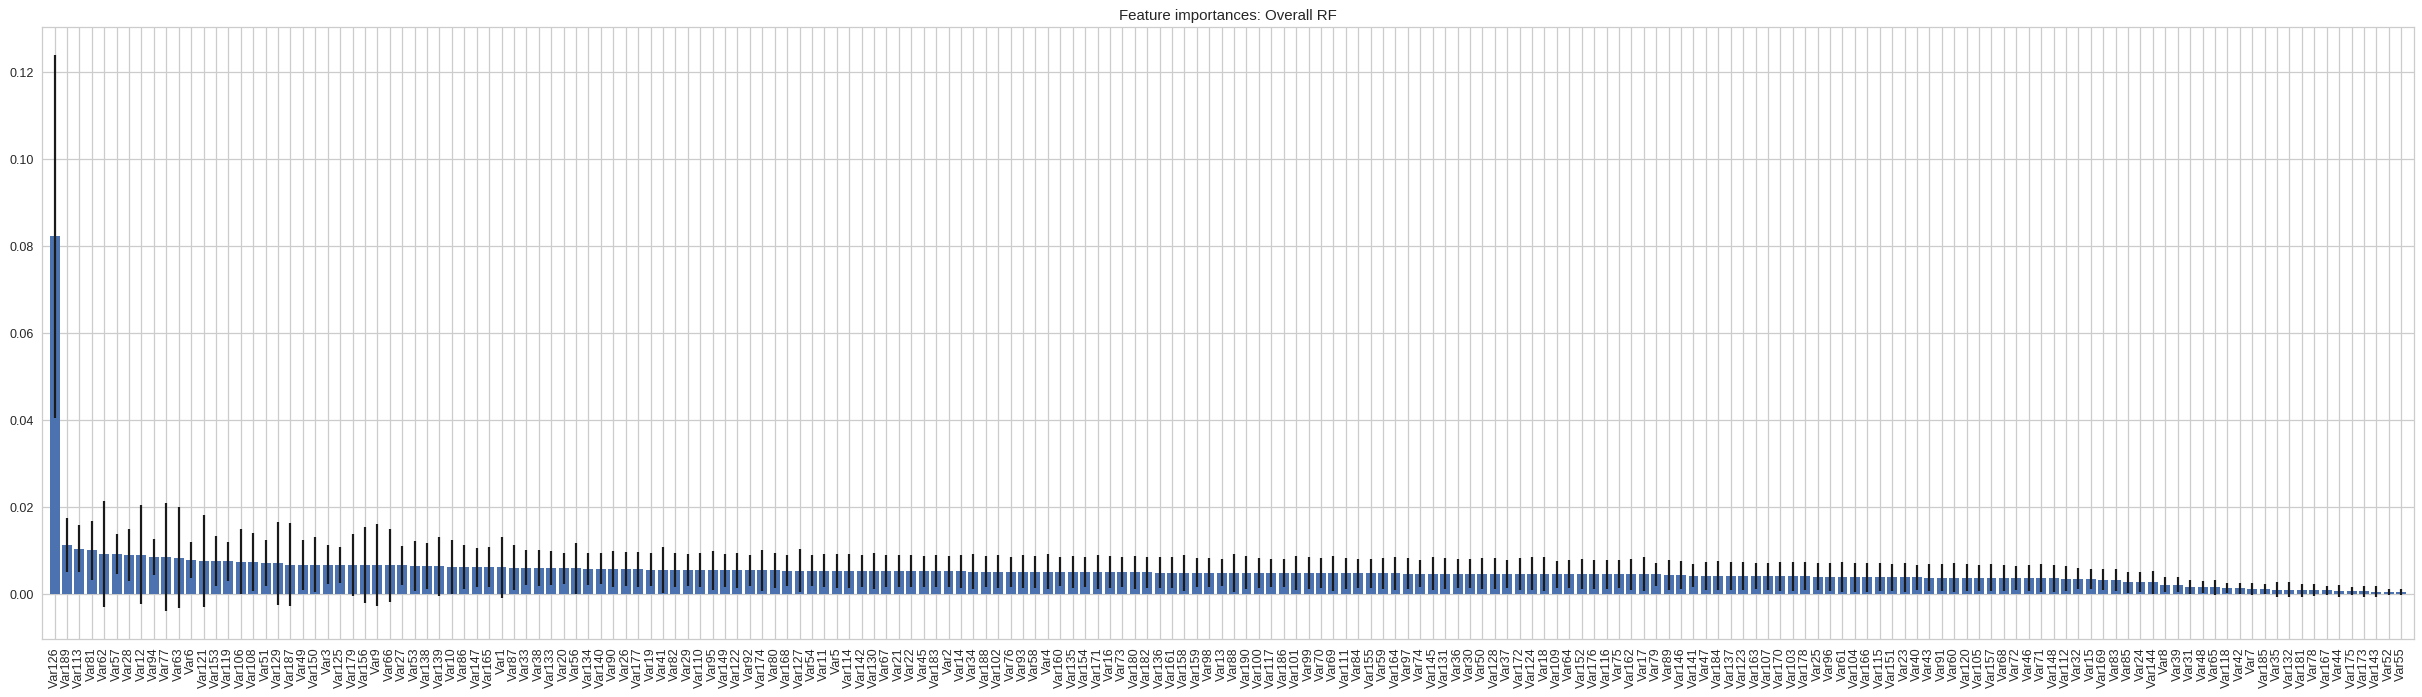

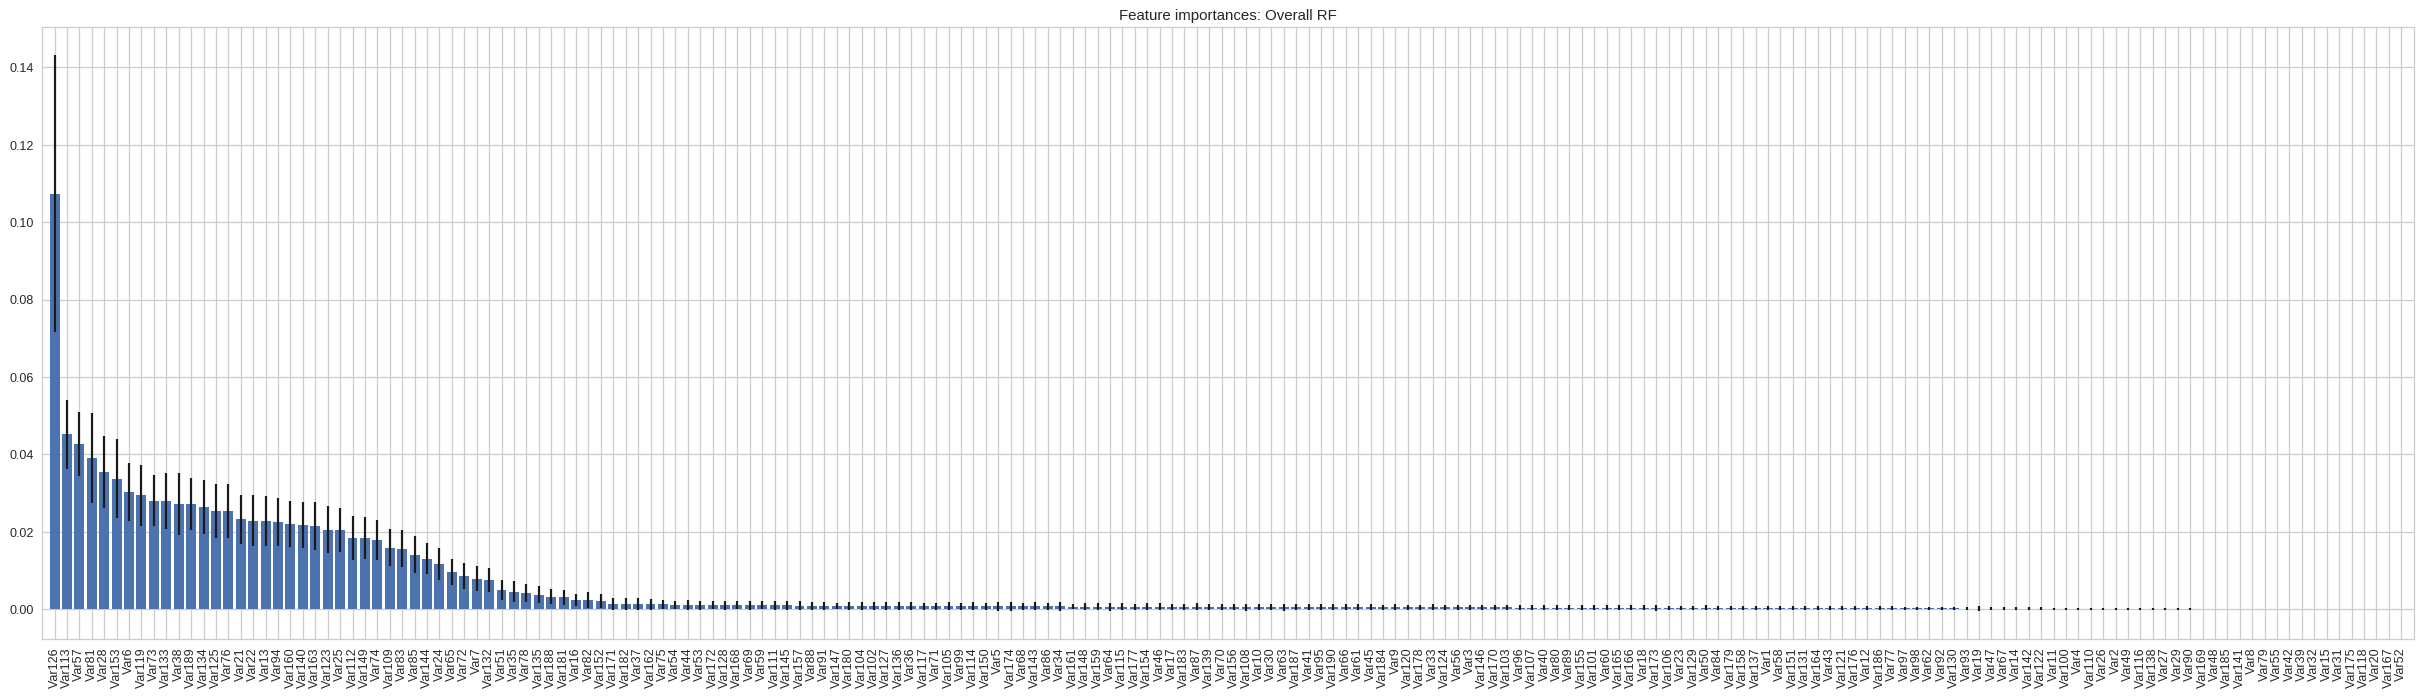

([array([125, 171, 151, 146,  81, 109,  80,  53, 145,  26,  27, 101,  50,
          29, 152, 167,  93, 118,   5, 134,   1,   2, 132,  37, 116, 133,
         169, 124, 158,  52,  75, 153,  88, 163, 159, 113,  20,  86,  21,
         139, 189, 178, 148, 112,  85,  16, 179,  12, 162,  18, 164,  42,
          74, 188,  24,  44,   9, 160,  39, 120, 108, 111, 170, 105,  73,
         110,  32, 122, 181, 144,  69,  58,   3,  40, 177, 157, 149,  95,
          55,  92,  36,  17, 138,  56,  61, 161, 104, 107, 173,  91, 135,
          11,  22, 187, 128,  62,  46, 103,  76,  68, 130,  63,  87, 176,
         165, 106, 127,  98,  59, 141,  48, 185,  71,  33,  15,  57, 123,
         100, 119,  49,  96,  99, 183,  45, 175, 147, 136, 154, 102,  94,
          10, 121,  82, 137, 182, 129, 186, 150,  89, 156,  13,  70,  28,
          79,   4,  97, 126,  67,  25,   0, 114,  60,  84,  83, 115,   8,
          23,  35,  65,  66,  90, 155,  72, 143,  64, 131,  34,   6,  77,
         142, 180,  43, 172,  54, 117,

In [15]:
# RF feature importances for each imputer
clf = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=seed, n_jobs=-1)
scoring = 'featimp'
features = X.columns
_ = testImpute(imputers, clf, X, y2, scoring, cv_n=folds, seed=seed, plot=False)

In [ ]:
# metric: neg log loss
# 500 trees & stratified CV
folds = 10
clf = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=seed, n_jobs=-1)
scoring = 'neg_log_loss'
testImpute(imputers, clf, X, y2, scoring, suf='ups', cv_n=folds, seed=seed)

In [ ]:
# metric: precision
# 500 trees & stratified
folds = 10
clf = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=seed, n_jobs=-1)
scoring = 'precision'
testImpute(imputers, clf, X, y2, scoring, suf='ups', cv_n=folds, seed=seed)

# Gridsearch Random Forest # of Trees w CV

In [22]:
# grid search: number of trees with CV
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': [500, 1000, 2000, 3000, 4000]}
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

clf = GridSearchCV(rf, params, scoring='neg_log_loss', n_jobs=-1)
clf.fit(X.fillna(-99999), y2)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 1000, 2000, 3000, 4000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

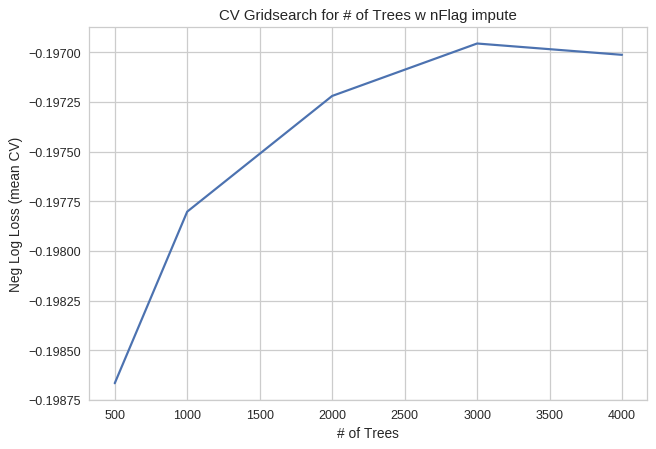

In [27]:
plt.plot(params['n_estimators'], clf.cv_results_['mean_test_score'])
plt.xlabel('# of Trees')
plt.ylabel('Neg Log Loss (mean CV)')
plt.title('CV Gridsearch for # of Trees w nFlag impute')
fig = plt.gcf()
fig.savefig('figs/rf_gdSearch_nTrees_ups.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
del clf

In [29]:
def precisionRecall(clf, X, y, cv_n=10, suf='', seed=seed, plot=True):
    skf = StratifiedKFold(n_splits=folds, random_state=seed)
    scores = np.empty(X.shape[0])
    scores.fill(np.nan)
    for train, test in skf.split(X, y):
        x_train = X.iloc[train]
        x_test = X.iloc[test]
        y_train = y[train]
        y_test = y[test]
        
        clf.fit(x_train, y_train)
        try:
            y_scores = clf.decision_function(x_test)
        except Exception:
            y_scores = clf.predict_proba(x_test)[:, 1]
        scores[test] = y_scores
        
    precision, recall, _ = precision_recall_curve(y, scores)
    print np.shape(recall), np.shape(precision)
    pr_auc = average_precision_score(y, scores)
    
    if plot:
        plt.plot(recall, precision)
        plt.xlabel('Recall (mean CV)')
        plt.ylabel('Precision (mean CV)')
        plt.title('Precision-Recall Curve: AUC={0:0.2f} \n {1}-fold Strat CV'.format(np.mean(pr_auc), folds))
        fig = plt.gcf()
        fig.savefig('figs/rfcv_precision_recall_curve_' + suf + '.png')
        plt.show()
    return pr_auc, precision, recall 

## Random Forest: Precision-Recall

Precision-Recall w/ nFlag Imputation
(18,) (18,)
() ()


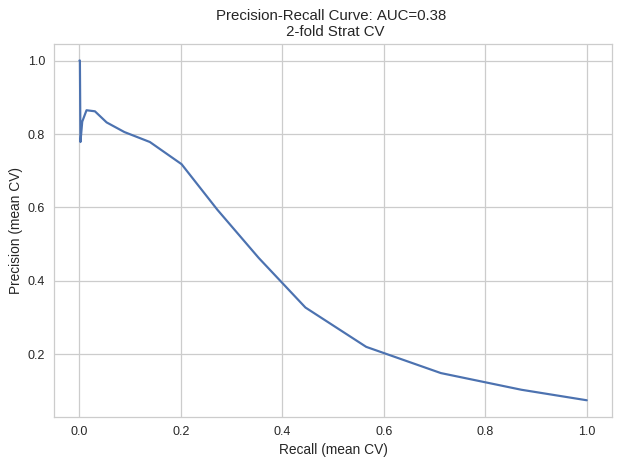

In [24]:
# metric: precision
# 500 trees & stratified
print('Precision-Recall w/ nFlag Imputation')
folds = 10
clf = RandomForestClassifier(n_estimators=20, class_weight='balanced', random_state=seed, n_jobs=-1)
scoring = 'precision'
auc, precision, recall = precisionRecall(clf, X.fillna(-99999), y2, cv_n=folds, suf='ups', seed=seed)

## Gradient Boosting: Precision-Recall

Precision-Recall w/ nFlag Imputation
(48305,) (48305,)
() ()


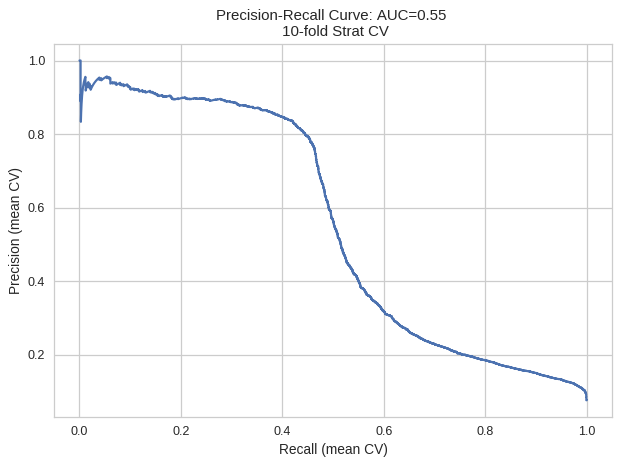

In [27]:
# metric: precision
# 500 trees & stratified
print('Precision-Recall w/ nFlag Imputation')
folds = 10
clf = XGBClassifier(n_estimators=500, nthread=-1)
scoring = 'precision'
auc, precision, recall = precisionRecall(clf, pd.concat([pd.DataFrame(X.fillna(-99999), columns=X.columns), Xhot], axis=1), y2, cv_n=folds, suf='ups', seed=seed)

Precision-Recall w/ SoftImpute & Gradient Boosting
(49233,) (49233,)
() ()


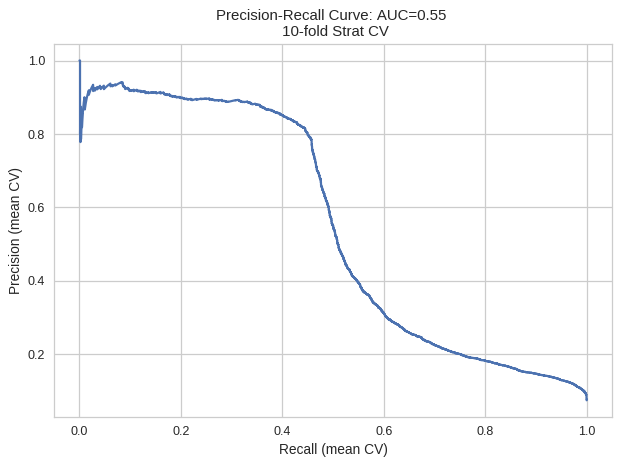

In [28]:
# metric: precision
# 500 trees & stratified
print('Precision-Recall w/ SoftImpute & Gradient Boosting')
folds = 10
imputer = SoftImpute(verbose=False)
clf = XGBClassifier(n_estimators=500, nthread=-1)
scoring = 'precision'
auc, precision, recall = precisionRecall(clf, pd.concat([pd.DataFrame(imputer.complete(X), columns=X.columns), Xhot], axis=1), y2, cv_n=folds, suf='ups', seed=seed)

Precision-Recall w/ nFlag Imputation & Gradient Boosting only on floats
(47838,) (47838,)


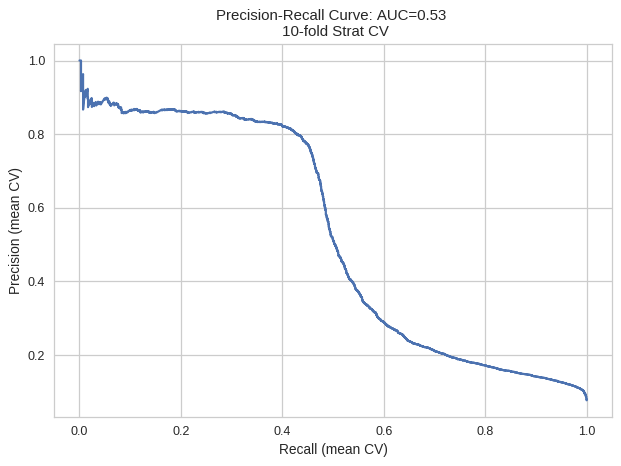

In [30]:
# metric: precision
# 500 trees & stratified
print('Precision-Recall w/ nFlag Imputation & Gradient Boosting only on floats')
folds = 10
imputer = SoftImpute(verbose=False)
clf = XGBClassifier(n_estimators=500, nthread=-1)
scoring = 'precision'
auc, precision, recall = precisionRecall(clf, X.fillna(-99999), y2, cv_n=folds, suf='ups', seed=seed)

* Precision-recall AUC is lower when only numerical floats are included in training
* Hence, the 1-hot encoded categorical variables are providing information predictive of Upsell
* Categorical predictors are included in all models below

In [25]:
def testAlgorithms(models, X, y, cv_n, seed, scoring, suf, impName, plot=True):
    # test each algorithm
    results = []
    names = []
    for name, model, _ in models:
        # select either (non)colinear features depending on model assumptions
        x = X
        kf = StratifiedKFold(n_splits=cv_n, random_state=seed)
        if scoring == 'predict':
            cv_results = cross_val_predict(model, x, y, cv=kf, method=scoring, n_jobs=-1)
        else:
            cv_results = cross_val_score(model, x, y, cv=kf, scoring=scoring, n_jobs=-1)
            print("{0}: {1} ({2}) acc (std)".format(name, cv_results.mean(), cv_results.std()))
        results.append(cv_results)
        names.append(name)        
        
    if plot:
        # Plot & Compare model's performance
        fig, ax = plt.subplots()
        ax.boxplot(results, notch=False, patch_artist=True)
        ax.set_xticklabels(names)
        plt.title('Algorithm Accuracy ('+ suf +')', fontsize=20)
        fig = plt.gcf()
        fig.savefig('figs/base_alg_nlogloss'+ suf + impName + '.png', bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.show()
    return results, names

## Performance (log loss) Algorithms: with SoftImpute (soft thresholding of SVD) used to impute missing float values

In [20]:
# setup BINARY models
models = []
models.append(('RFg', RandomForestClassifier(criterion='gini', n_estimators=500, max_depth=None, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('RFe', RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=None, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTg', ExtraTreesClassifier(criterion='gini', n_estimators=500, max_depth=None, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTe', ExtraTreesClassifier(criterion='entropy', n_estimators=500, max_depth=None, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('LR', LogisticRegression(solver='lbfgs', class_weight='balanced'), False))#
models.append(('LDA', LinearDiscriminantAnalysis(), False))
models.append(('NB', GaussianNB(), False))
models.append(('xGB', XGBClassifier(n_estimators=500, nthread=-1), True))
models.append(('MLP', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(500,), activation='relu', alpha=1e-5, learning_rate_init=1e-3, learning_rate='constant', random_state=seed, momentum=0.7), True))
models.append(('Dum', DummyClassifier(strategy='most_frequent'), True))

Imputation Method:sSVD - All features:
 Upsell

RFg: -0.190839085696 (0.00328754619404) acc (std)
RFe: -0.192451525329 (0.00369548881349) acc (std)
XTg: -0.199744373538 (0.00313068492833) acc (std)
XTe: -0.199455543058 (0.00295188776283) acc (std)
LR: -0.507736922956 (0.0114820059579) acc (std)


/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: -0.232284954138 (0.00572532531622) acc (std)
NB: -27.0186421277 (0.17601510272) acc (std)
xGB: -0.167547438774 (0.00435649920461) acc (std)
MLP: -1.35042820397 (0.189487616182) acc (std)
Dum: -2.54343525814 (0.00251609447122) acc (std)


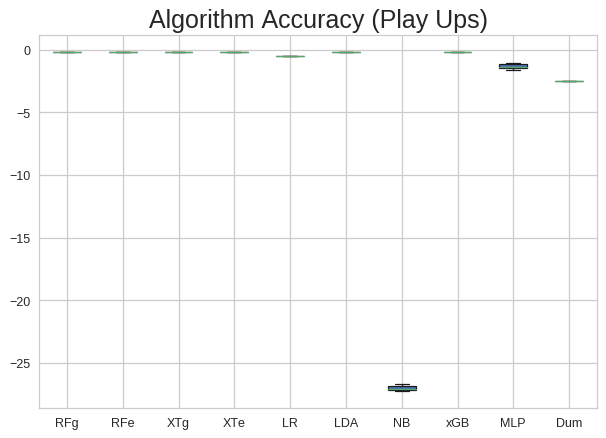

Imputation Method:lSVD - All features:
 Upsell

RFg: -0.205728807275 (0.00205419706905) acc (std)
RFe: -0.204711892573 (0.00227918318965) acc (std)
XTg: -0.220186362333 (0.00236070874722) acc (std)


KeyboardInterrupt: 

In [19]:

# Using only top 20 features
# topf = features[idxDir[:20]]
scoring = 'neg_log_loss'
folds = 10
for impName, imputer in imputers:
    print('Imputation Method:' + impName + ' - All features:\n Upsell\n')
    # test algorithms for upsell
    # x = pd.DataFrame(imputer.complete(X), columns=X.columns)
    resUps, names = testAlgorithms(models, pd.concat([pd.DataFrame(imputer.complete(X), columns=X.columns), Xhot], axis=1), y2, folds, seed, scoring, suf='Ups', impNm=impName)

## Performance (log loss) of Algorithms: with large negative flag (nFlag) used to impute missing float values

In [ ]:
# setup BINARY models
models = []
models.append(('RFg', RandomForestClassifier(criterion='gini', n_estimators=500, max_depth=None, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('RFe', RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=None, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTg', ExtraTreesClassifier(criterion='gini', n_estimators=500, max_depth=None, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('XTe', ExtraTreesClassifier(criterion='entropy', n_estimators=500, max_depth=None, class_weight='balanced', min_samples_split=2, min_samples_leaf=1, n_jobs=-1), True))
models.append(('LR', LogisticRegression(solver='lbfgs', class_weight='balanced'), False))#
models.append(('LDA', LinearDiscriminantAnalysis(), False))
#models.append(('NB', GaussianNB(), False))
models.append(('xGB', XGBClassifier(n_estimators=500, nthread=-1), True))
#models.append(('MLP', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(500,), activation='relu', alpha=1e-5, learning_rate_init=1e-3, learning_rate='constant', random_state=seed, momentum=0.7), True))
models.append(('Dum', DummyClassifier(strategy='most_frequent'), True))

Imputation Method:nFlag - All features:
 Upsell

RFg: -0.206870738122 (0.00180991492393) acc (std)
RFe: -0.205965632088 (0.00245026327292) acc (std)
XTg: -0.226317773535 (0.00397857590515) acc (std)
XTe: -0.227127517427 (0.0028756054156) acc (std)
LR: -0.683265480944 (0.00239915482504) acc (std)


/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jsync/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: -0.26005182279 (0.00534036309958) acc (std)
xGB: -0.166677840515 (0.00432509214047) acc (std)
Dum: -2.54343525814 (0.00251609447122) acc (std)


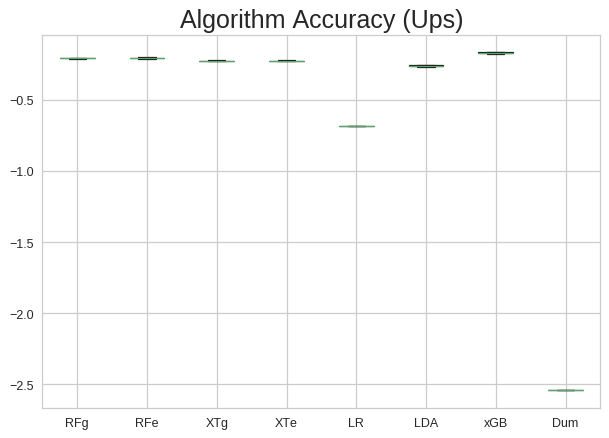

In [28]:
imputers = imputers[1:]
# Using only top 20 features
# topf = features[idxDir[:20]]
scoring = 'neg_log_loss'
folds = 10
impName = 'nFlag'
print('Imputation Method:' + impName + ' - All features:\n Upsell\n')
# test algorithms for upsell
# x = pd.DataFrame(imputer.complete(X), columns=X.columns)
resUps, names = testAlgorithms(models, pd.concat([pd.DataFrame(X.fillna(-99999), columns=X.columns), Xhot], axis=1), y2, folds, seed, scoring, suf='Ups', impName=impName)

* Gradient boosting with XGboost out performed all other algorithms
* XGboost offered excellent predicted performance, with a negative log loss of -0.166, when using a large negative value flag (nFlag) for missing values
* nFlag provided slightly better impuation than SoftImpute, with a negative log loss of -0.166 vs -0.167, although both provided great solutions